runs the same code as heat_1d_1d_example.ipynb but now with the new heat_nn implementation

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from heat_combined2 import heat_nn
np.random.seed(238)
torch.manual_seed(301)

Epoch 74, Loss: 19.601061, MSE: 0.080482
LBFGS Epoch 1, Loss: 2.413563


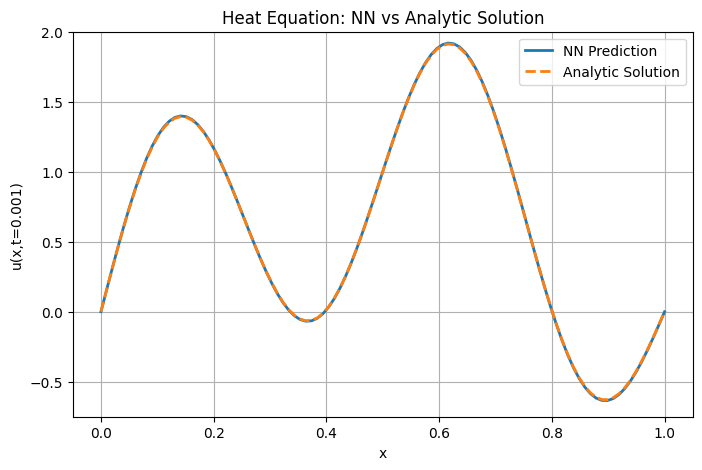

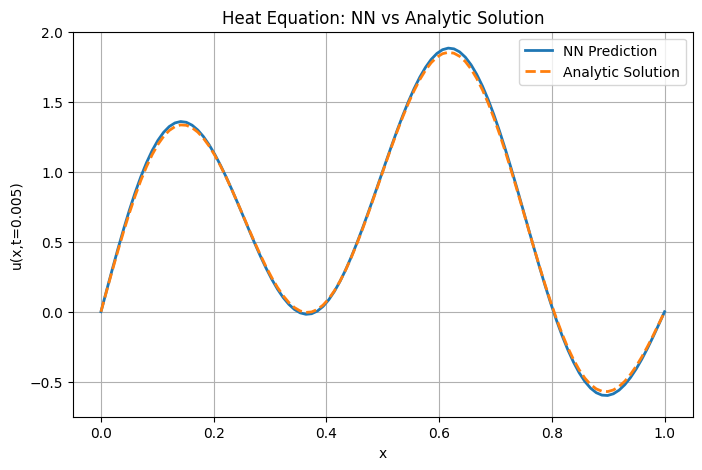

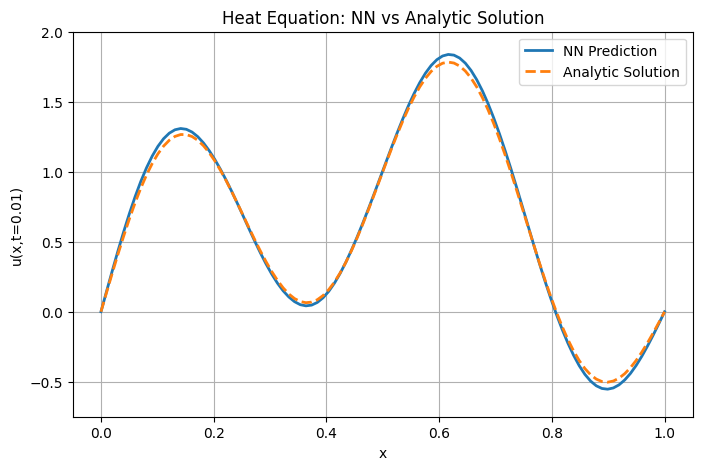

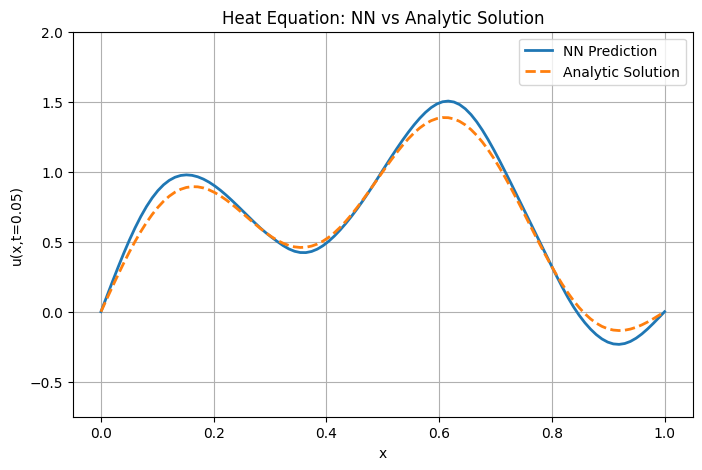

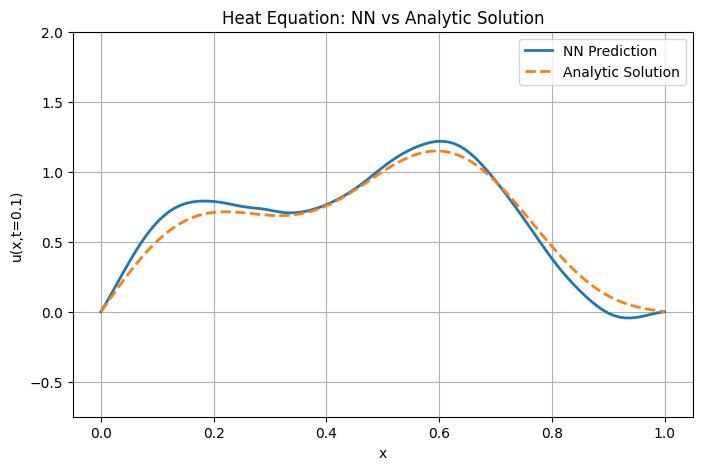

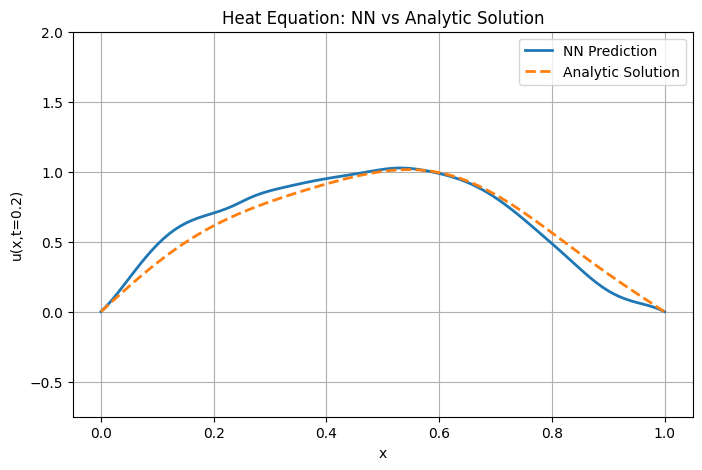

In [ ]:
layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]
dim=1
kappa = 0.1
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)
rhs = lambda x, t: torch.sin(torch.pi * x)
u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                    ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)


pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100
pde_nn.set_data(N_colloc)

# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 75, opt_time_scale =True, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=1, max_iter=100)

for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()


    #compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic = (1 - 1 / (0.1 * np.pi**2)) * np.sin(np.pi * x_np) * np.exp(-np.pi**2 * 0.1 * t_val
                    ) + np.sin(4 * np.pi * x_np) * np.exp(- 16 * np.pi**2 * 0.1 * t_val
                    ) + 1 / (0.1 * np.pi**2) * np.sin(np.pi * x_np) 

    # Plot the results
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_pred, label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic, '--', label='Analytic Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
"""
2D Heat equation
"""

layers = [32, 64, 128, 128, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

u_0 = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y)

u_analytic = lambda x, y,t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(
    -2 * torch.pi**2 * t) + torch.sin(2 * torch.pi * x) * torch.sin(4 * torch.pi * x
    ) * torch.exp(-20 * torch.pi**2 * t)

dim=2
kappa = 1
rhs = lambda x, y, t: 0
N_colloc = 50



pde_nn = heat_2d_nn(layers, activations)

pde_nn.train(x_colloc, y_colloc, t_colloc, lr=1e-2, weight_decay=0, epochs = 1_000, print_epochs=50)
#proper result for epochs =5000
pde_nn.train_lbfgs(x_colloc, t_colloc, lr=1, epochs=20, max_iter=30)

x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()


#compare results with analytic solution

x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
y_np = y_test.numpy().flatten()
t_val = 0.5
u_analytic = np.sin(np.pi * x_np) * np.sin(np.pi * y_np) * np.exp(
    -2 * np.pi**2 * t_val) + np.sin(2 * np.pi * x_np) * np.sin(4 * np.pi * x_np
    ) * np.exp(-20 * np.pi**2 * t_val)